In [47]:
%matplotlib inline
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import pandas as pd
import corner
import astropy
import astropy.units as u

In [48]:
columns=['name','redshift','distance_mod','DM_err','SN_prob']
rawdat=pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\s',names=columns, header=5, engine='python')

In [49]:
data=np.sort(rawdat.T, axis=0)
zs = rawdat.redshift
mm = rawdat.distance_mod
dm = rawdat.DM_err

In [50]:
from astropy.cosmology import FlatLambdaCDM

In [51]:
def DM(z,H0,Om):
    cosmo = FlatLambdaCDM(H0=70* u.km / u.s / u.Mpc, Om0=0.3)
    DL=cosmo.luminosity_distance(z)
    mag=5*np.log10((DL/(10*u.pc)).decompose())
    return mag

In [52]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [53]:
p = lmfit.Parameters()
p.add_many(('Om',0.3,True,0.,2.),('H0',70.0,True,50.,100.))

def residual(p):
    v = p.valuesdict()
    return (DM(zs,v['H0'],v['Om'])-mm)/dm

In [54]:
print p

Parameters([('Om', <Parameter 'Om', 0.3, bounds=[0.0:2.0]>), ('H0', <Parameter 'H0', 70.0, bounds=[50.0:100.0]>)])


In [55]:
mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 39
    # data points      = 579
    # variables        = 2
    chi-square         = 564.653902
    reduced chi-square = 0.97860295
    Akaike info crit   = -10.5268192
    Bayesian info crit = -1.80421422
[[Variables]]
    Om:  0.30000000 (init = 0.3)
    H0:  70.0000000 (init = 70)


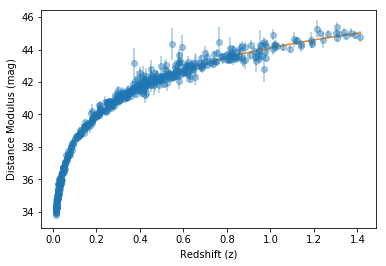

In [56]:
s = (zs.sort_values()).index
plt.errorbar(zs[s],mm[s],yerr=dm[s],fmt='o',alpha=0.4)
bestOm = mi.params.valuesdict()['Om']
bestH0 = mi.params.valuesdict()['H0']
plt.plot(zs[s],DM(zs[s],bestH0,bestOm))
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mag)')
lmfit.report_fit(mi)

In [57]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1500, thin=1,
                         params=mi.params, is_weighted=True)

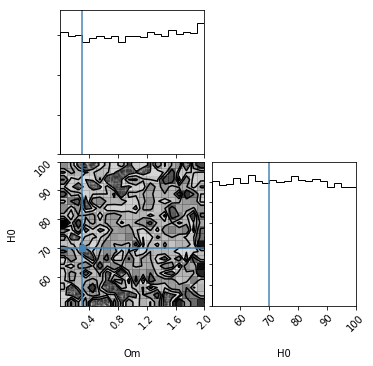

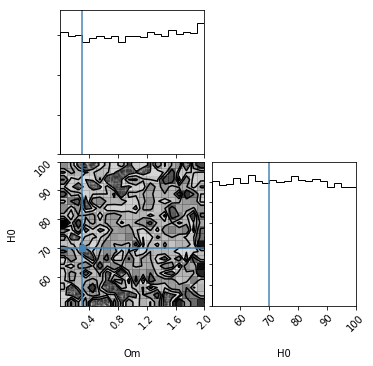

In [58]:
corner.corner(res.flatchain,labels=mi.var_names, truths=list(mi.params.valuesdict().values()))